In [1]:
# install for AWS
# !pip uninstall cryptography 
!pip install --upgrade cryptography==36.0.2 --quiet
!pip install torch --quiet
!pip install pandas --quiet
!pip install scikit-image --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet
!pip install torchvision --quiet
!pip install s3fs --quiet
!pip install boto3 --quiet
!pip install tqdm --quiet
!pip install fiftyone --quiet
!pip install pycocotools --quiet
!pip install super-gradients --quiet

DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can 

In [3]:
# from utils.loss_functions import DKDLoss
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
# from tqdm import tqdm
# from models_package.models import Teacher, Student
# from torchvision import datasets, transforms, models
# import models_package
# import time
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # new libraries
# from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider

In [2]:
import os
import torch
import tarfile
import shutil
import torchvision
import random
import warnings
import boto3
import s3fs
import io
import time
import botocore.exceptions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import getpass
import json
# import torch.jit as jit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models, datasets
from torch import nn, optim
from torch.optim import lr_scheduler
from io import BytesIO
from tqdm import tqdm
from skimage import io, transform
from PIL import Image
from pycocotools import mask as maskUtils

warnings.filterwarnings("ignore")

import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz
from fiftyone import ViewField as F

## Configure YOLO-NAS for Fiftyone

follow this medium article (https://medium.com/voxel51/state-of-the-art-object-detection-with-yolo-nas-fiftyone-f1530826b28e)

In [6]:
## random dataset to test

test_dataset = foz.load_zoo_dataset(
    "coco-2017", 
    split = "validation", 
    max_samples=1000
)

test_dataset.name = "YOLO-NAS-demo1" 
test_dataset.persistent = True

Found annotations at '/home/ubuntu/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [22]:
!ls /home/ubuntu/fiftyone/coco-2017/validation/data/000000000139.jpg

000000000139.jpg  000000025593.jpg  000000057027.jpg  000000088040.jpg
000000000285.jpg  000000025603.jpg  000000057149.jpg  000000088218.jpg
000000000632.jpg  000000025986.jpg  000000057150.jpg  000000088250.jpg
000000000724.jpg  000000026204.jpg  000000057232.jpg  000000088265.jpg
000000000776.jpg  000000026465.jpg  000000057238.jpg  000000088269.jpg
000000000785.jpg  000000026564.jpg  000000057244.jpg  000000088345.jpg
000000000802.jpg  000000026690.jpg  000000057597.jpg  000000088432.jpg
000000000872.jpg  000000026926.jpg  000000057672.jpg  000000088462.jpg
000000000885.jpg  000000026941.jpg  000000057725.jpg  000000088485.jpg
000000001000.jpg  000000027186.jpg  000000057760.jpg  000000088848.jpg
000000001268.jpg  000000027620.jpg  000000058029.jpg  000000088951.jpg
000000001296.jpg  000000027696.jpg  000000058111.jpg  000000088970.jpg
000000001353.jpg  000000027768.jpg  000000058350.jpg  000000089045.jpg
000000001425.jpg  000000027932.jpg  000000058384.jpg  000000089078.jpg
000000

In [7]:
#  store image width and height, so that we can use these to convert 
#     between absolute and relative coordinates for bounding boxes
test_dataset.compute_metadata()

In [8]:
## get yolo-nas
from super_gradients.training import models 
model = models.get("yolo_nas_l", pretrained_weights="coco")

[2023-11-11 11:33:42] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-11 11:33:42] WARNING - __init__.py - Failed to import pytorch_quantization


The console stream is logged into /home/ubuntu/sg_logs/console.log


[2023-11-11 11:33:43] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-11 11:33:43] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-11 11:33:43] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-11 11:33:44] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-11-11 11:33:45] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


Generating YOLO-NAS Predictions
- generate predictions for a single sample by passing the filepath for the sample’s image to our model’s `predict()` method, along with an optional confidence threshold:

In [9]:
sample = test_dataset.first() 
sample

<Sample: {
    'id': '654f66667f10317117add492',
    'media_type': 'image',
    'filepath': '/home/ubuntu/fiftyone/coco-2017/validation/data/000000000139.jpg',
    'tags': ['validation'],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 640,
        'height': 426,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '654f66667f10317117add47e',
                'attributes': {},
                'tags': [],
                'label': 'potted plant',
                'bounding_box': [
                    0.37028125,
                    0.3345305164319249,
                    0.038593749999999996,
                    0.16314553990610328,
                ],
                'mask': None,
                'confidence': None,
                'index': None,
                'supercategory': 'furniture',
                'iscrowd': 0,
            }>,
     

In [10]:
prediction = model.predict(sample.filepath, conf = 0.25)

[2023-11-11 11:33:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


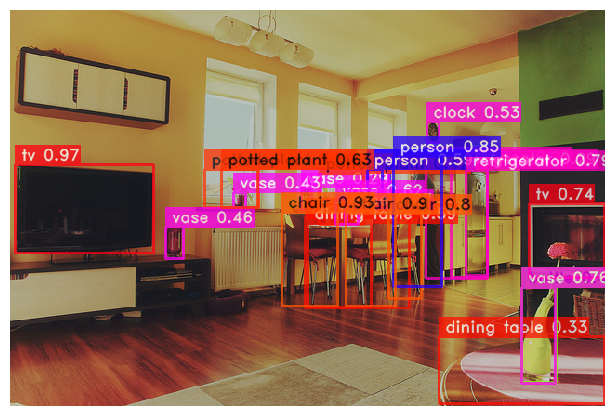

In [11]:
prediction.show()

To efficiently generate predictions for all of the images in our dataset, we batch these operations by passing the model the names of all the filepaths for all of our images

In [14]:
fps, widths, heights = test_dataset.values(
    ["filepath", "metadata.width", "metadata.height"]
) 

## batch predictions 
preds = model.predict(fps, conf = .8)._images_prediction_lst

Predicting Images:  96%|███████████████████████████████████████████████████████████████▍  | 961/1000 [07:58<00:18,  2.07it/s]

To load these predictions into FiftyOne, we need to first convert these into Detection label objects. This will require accessing the internals of the prediction objects, extracting the confidence, labels, and bounding boxes.

We can access this information via the _images_prediction_lst attribute of the prediction objects. Let's see what this looks like for a single image.

In [15]:
pred = model.predict(sample.filepath, conf = 0.9)._images_prediction_lst[0]
print(pred)

Predicting Images: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [08:02<00:00,  2.07it/s]
[2023-11-11 11:47:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


For lists of input images, the _images_prediction_lst attribute is a generator, and we can use next() to see what it generates, which is an ImageDetectionPrediction object. For a single image input, a list is returned instead. In this result, we can see bounding boxes stored in xyxy format, an array of confidence scores, and an array of integers representing the indices of the label classes in the class_names array for those detections. The class names are precisely the COCO class names.

Here is how we can convert bounding boxes from YOLO-NAS output coordinates:

In [16]:
def convert_bboxes(bboxes, w, h):
    tmp = np.copy(bboxes[:, 1])
    bboxes[:, 1] = h - bboxes[:, 3]
    bboxes[:, 3] = h - tmp
    bboxes[:, 0]/= w
    bboxes[:, 2]/= w
    bboxes[:, 1]/= h
    bboxes[:, 3]/= h
    bboxes[:, 2] -= bboxes[:, 0]
    bboxes[:, 3] -= bboxes[:, 1]
    bboxes[:, 1] = 1 - (bboxes[:, 1] + bboxes[:, 3])
    return bboxes

Applying this bounding box conversion, we can generate FiftyOne Detection objects for each object, and create a Detections object containing a list of detected objects for a given image:

In [17]:
def generate_detections(p, width, height):
    class_names = p.class_names
    dp = p.prediction
    bboxes, confs, labels = np.array(dp.bboxes_xyxy), dp.confidence, dp.labels.astype(int)
    if 0 in bboxes.shape:
        return fo.Detections(detections = [])
    
    bboxes = convert_bboxes(bboxes, width, height)
    labels = [class_names[l] for l in labels]
    detections = [
        fo.Detection(
            label = l,
            confidence = c,
            bounding_box = b
        )
        for (l, c, b) in zip(labels, confs, bboxes)
    ]
    return fo.Detections(detections=detections)

Putting it all together, we can efficiently add YOLO-NAS detection predictions to our dataset:

In [18]:
def add_YOLO_NAS_predictions(dataset, confidence = 0.9):
    ## aggregation to minimize expensive operations
    fps, widths, heights = dataset.values(
        ["filepath", "metadata.width", "metadata.height"]
    )
    
    ## batch predictions
    preds = model.predict(fps, conf = confidence)._images_prediction_lst
    
    ## add all predictions to dataset at once
    dets = [
        generate_detections(pred, w, h)
        for pred, w, h in zip(preds, widths, heights)
    ]
    dataset.set_values("YOLO-NAS", dets)

Applying this to our dataset and launching a session of the FiftyOne App, we can visualize the results:

In [19]:
add_YOLO_NAS_predictions(test_dataset, confidence = 0.7) 
session = fo.launch_app(test_dataset)

ImageDetectionPrediction(image=array([[[170, 136,  73],
        [173, 142,  77],
        [175, 144,  79],
        ...,
        [ 69,  76,  42],
        [ 68,  76,  39],
        [ 70,  71,  37]],

       [[172, 141,  77],
        [176, 145,  80],
        [177, 146,  81],
        ...,
        [ 69,  77,  40],
        [ 72,  80,  43],
        [ 71,  75,  40]],

       [[175, 144,  79],
        [177, 146,  81],
        [178, 147,  80],
        ...,
        [ 70,  78,  39],
        [ 69,  77,  40],
        [ 71,  75,  40]],

       ...,

       [[188, 189, 157],
        [183, 183, 149],
        [193, 187, 153],
        ...,
        [186, 157, 153],
        [186, 157, 153],
        [187, 156, 154]],

       [[186, 183, 152],
        [187, 184, 153],
        [186, 183, 152],
        ...,
        [198, 134, 134],
        [195, 120, 124],
        [186,  88, 101]],

       [[186, 183, 150],
        [187, 184, 151],
        [186, 183, 152],
        ...,
        [129,  60,  63],
        [126,  57,

Predicting Images: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [08:07<00:00,  2.05it/s]



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.22.2

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



[2023-11-11 11:56:12] INFO - session.py - 
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.22.2

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



#### Evaluation
With the data loaded into FiftyOne, we can evaluate the quality of the object detection predictions against the “ground truth” with FiftyOne’s evaluate_detections() method. We will store the results with an evaluation key so we can view the resulting evaluation patches in the FiftyOne App:

In [20]:
res = test_dataset.evaluate_detections(
    "YOLO-NAS", 
    eval_key="eval_yolonas"
) 
session.view = test_dataset.to_evaluation_patches("eval_yolonas")

Evaluating detections...


[2023-11-11 11:56:12] INFO - detection.py - Evaluating detections...


 100% |███████████████| 1000/1000 [11.9s elapsed, 0s remaining, 100.4 samples/s]      


[2023-11-11 11:56:24] INFO - utils.py -  100% |███████████████| 1000/1000 [11.9s elapsed, 0s remaining, 100.4 samples/s]      


We can click into one of these evaluation patches and, hovering over the detection, we can see attributes like intersection over union (IoU) score, and whether the prediction was a true positive, false positive, or false negative.

If we wanted to see images with the most false positives, we could sort the dataset accordingly:

In [21]:
### get images with the most FP's first 
fp_view = test_dataset.sort_by("eval_yolonas_fp", reverse = True)

We can also dig into the performance data more quantitatively by printing metrics for the most commonly occurring classes in the dataset:

In [22]:
counts = test_dataset.count_values("ground_truth.detections.label") 
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10] 
# Print a report for the top-10 classes 
res.print_report(classes=classes_top10)

              precision    recall  f1-score   support

      person       0.98      0.52      0.68      2259
       chair       0.88      0.33      0.48       401
         car       0.93      0.42      0.58       348
        book       1.00      0.03      0.06       212
      bottle       0.88      0.28      0.43       210
         cup       0.97      0.45      0.61       185
dining table       0.85      0.18      0.30       153
        bowl       0.86      0.34      0.49       128
        bird       1.00      0.39      0.56       103
    backpack       1.00      0.07      0.13        98

   micro avg       0.95      0.42      0.58      4097
   macro avg       0.93      0.30      0.43      4097
weighted avg       0.95      0.42      0.57      4097



## FACET Dataset with YOLO

In [3]:
########## LM ##########

access_key = getpass.getpass("Enter your access: ")

secret_key = password = getpass.getpass("Enter your secret: ")

bucket_name = 'w210facetdata'
annotations_prefix = 'annotations/'
images_prefix = '/home/ubuntu/W210-Capstone'

s3 = s3fs.S3FileSystem(key=access_key, secret=secret_key)

# Use s3.open to open the CSV file and read its content into a Pandas DataFrame
with s3.open(f's3://{bucket_name}/{annotations_prefix}annotations.csv', 'rb') as file:
    gt_df = pd.read_csv(file)

Enter your access:  ········
Enter your secret:  ········


In [12]:
# use relative paths to your image dirs
dataset = fo.Dataset(name = "IDP_MB", persistent=True)
# dataset = fo.load_dataset('IDP')
dataset.add_images_dir(images_prefix)
dataset.compute_metadata()

 100% |█████████████| 22236/22236 [3.3s elapsed, 0s remaining, 6.8K samples/s]      


[2023-11-11 11:37:34] INFO - utils.py -  100% |█████████████| 22236/22236 [3.3s elapsed, 0s remaining, 6.8K samples/s]      


Computing metadata...


[2023-11-11 11:37:35] INFO - metadata.py - Computing metadata...


 100% |█████████████| 22236/22236 [35.6s elapsed, 0s remaining, 745.7 samples/s]      


[2023-11-11 11:38:10] INFO - utils.py -  100% |█████████████| 22236/22236 [35.6s elapsed, 0s remaining, 745.7 samples/s]      


In [ ]:

dataset.apply_model(yolov5, label_field="yolov5m")
### Just retain the "person" detections
people_view_values = dataset.filter_labels("yolov5m", F("label") == "person").values("yolov5m")
dataset.set_values("yolov5m", people_view_values)
dataset.save()

In [ ]:
def create_detection(row_index, sample):
    bbox_dict = json.loads(gt_df.loc[row_index, "bounding_box"])
    x, y, w, h = bbox_dict["x"], bbox_dict["y"], bbox_dict["width"], bbox_dict["height"]
    cat1, cat2 = bbox_dict["dict_attributes"]["cat1"], bbox_dict["dict_attributes"]["cat2"]

    person_id = gt_df.loc[row_index, "person_id"]

    img_width, img_height = sample.metadata.width, sample.metadata.height

    bounding_box = [x/img_width, y/img_height, w/img_width, h/img_height]
    detection = fo.Detection(
        label=cat1, 
        bounding_box=bounding_box,
        person_id=person_id,
        )

    detection["class2"] = cat2

    add_person_attributes(detection, row_index)
    add_protected_attributes(detection, row_index)
    add_other_attributes(detection, row_index)

    return detection